___
## Ciência dos Dados - PROJETO 3 - INSPER

___
#### Theo

#### Abel

#### Gustavo Pierre

#### Victor Jurdi

___

# Wines Review

___

## A. INTRODUÇÃO

Para o Projeto 3 de Ciências dos Dados, o grupo escolheu trabalhar com vinhos. O nosso DataSet contém 10 variavéis(Pais de origem,descrição do vinho,designação, pontos na avaliação, preço, provincia, região, variedade e a adega produtora. Com isso nosso grupo procura prever o preço do vinho através das variavéis mais qualificadas, que serão, o país, os pontos (nota do vinho) e o tipo da uva.

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

[Detalhe aqui as características da base de dados além da análise descritiva.]

In [6]:
import pandas as pd
import os
from matplotlib import pyplot as plt
#from operator import itemgetter

In [7]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Theo B.R.Theo_Barbara\Documents\GitHub\projeto_Cdata


### BASE DE DADOS

In [8]:
x=pd.read_csv('winemag-data_first150k.csv')
x.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [9]:
del x["Unnamed: 0"]

In [10]:
x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [11]:
x.dtypes

country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object

In [12]:
#x.variety.value_counts()

In [13]:
x["Frequencia"] = 0
x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,0
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,0
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,0
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,0
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,0


In [14]:
dic = {}
for e in x.variety:
    if e not in dic:
        dic[e] = 1
    
        
    elif e in dic:
        dic[e] +=1


In [15]:
lista = []
for e in dic:
    if dic[e] > 0:
        lista.append(dic[e]/len(dic))

In [16]:
dic2 = {}
i=0
for e in x.variety:
    if e not in dic2:
        dic2[e] = 1

In [17]:
i=0
for e in dic2:
    dic2[e] = lista[i]
    i+=1


In [18]:
lista2=[]
for uva in x.variety:
    lista2.append(dic2[uva])
        

In [19]:
x.Frequencia = lista2

In [20]:
x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,0.349684
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,0.039557


In [21]:
print(x.duplicated("Frequencia"))

0         False
1         False
2         False
3         False
4         False
5          True
6          True
7          True
8          True
9          True
10        False
11         True
12         True
13        False
14         True
15        False
16         True
17        False
18        False
19         True
20        False
21        False
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29        False
          ...  
150900     True
150901     True
150902     True
150903     True
150904     True
150905     True
150906     True
150907     True
150908     True
150909     True
150910     True
150911     True
150912     True
150913     True
150914     True
150915     True
150916     True
150917     True
150918     True
150919     True
150920     True
150921     True
150922     True
150923     True
150924     True
150925     True
150926     True
150927     True
150928     True
150929     True
Length: 150930, dtype: b

In [22]:
novo_x = x.drop_duplicates(['Frequencia'])
novo_x

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,0.349684
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,0.039557
10,Italy,"Elegance, complexity and structure come togeth...",Ronco della Chiesa,95,80.0,Northeastern Italy,Collio,NaN,Friulano,Borgo del Tiglio,0.216772
13,France,This wine is in peak condition. The tannins an...,Château Montus Prestige,95,90.0,Southwest France,Madiran,NaN,Tannat,Vignobles Brumont,0.221519
15,US,"First made in 2006, this succulent luscious Ch...",Sigrid,95,90.0,Oregon,Willamette Valley,Willamette Valley,Chardonnay,Bergström,22.914557
17,Spain,"Nicely oaked blackberry, licorice, vanilla and...",6 Años Reserva Premium,95,80.0,Northern Spain,Ribera del Duero,NaN,Tempranillo,Valduero,4.044304
18,France,Coming from a seven-acre vineyard named after ...,Le Pigeonnier,95,290.0,Southwest France,Cahors,NaN,Malbec,Château Lagrézette,5.075949


In [23]:
x.loc[(x.price<50),'Preço'] = 'Até 50'
x.loc[(x.price>50)&(x.price<=200),'Preço'] = 'Até 200'
#x.loc[(x.price>100)&(x.price<=200),'Preço'] = 'Até 200'
x.loc[(x.price>200)&(x.price<=400),'Preço'] = 'Até 400'
#x.loc[(x.price>300)&(x.price<=400),'Preço'] = 'Até 400'
x.loc[(x.price>400)&(x.price<=600),'Preço'] = 'Até 600'
#x.loc[(x.price>500)&(x.price<=600),'Preço'] = 'Até 600'
x.loc[(x.price>600)&(x.price<=800),'Preço'] = 'Até 800'
#x.loc[(x.price>700)&(x.price<=800),'Preço'] = 'Até 800'
x.loc[(x.price>800)&(x.price<=1000),'Preço'] = 'Até 1000'
#x.loc[(x.price>900)&(x.price<=1000),'Preço'] = 'Até 1000'
x.loc[(x.price>1000)&(x.price<=1500),'Preço'] = 'Até 1500'
#x.loc[(x.price>1500)&(x.price<=2000),'Preço'] = 'Até 2000'
x.loc[(x.price>2000),'Preço'] = 'Mais que 2000'

In [24]:
x.loc[(x.points<=80),'Pontos'] = '80 pontos'
x.loc[(x.points>80)&(x.points<=85),'Pontos'] = '81 - 85 pontos'
x.loc[(x.points>85)&(x.points<=90),'Pontos'] = '86 - 90 pontos'
x.loc[(x.points>90)&(x.points<=95),'Pontos'] = '91 - 95 pontos'
x.loc[(x.points>95)&(x.points<=100),'Pontos'] = '95 - 100 pontos'

### ANÁLISE DESCRITIVA

C:\Users\Theo B.R.Theo_Barbara\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


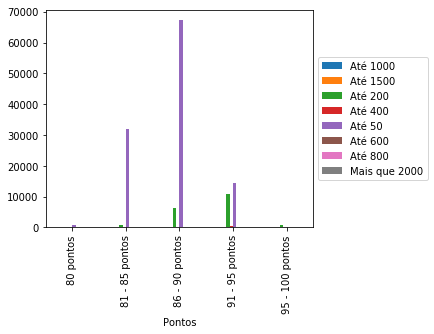

In [25]:
ct = pd.crosstab(x.Pontos, x.Preço)
ct.plot(kind='bar');
ax = plt.subplot(111);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [26]:
x.points.corr(x.price)

0.4598634287426046

In [27]:
x.Frequencia.corr(x.price)

0.11948549716429052

In [28]:
x.Frequencia.corr(x.points)

0.07755501939155625

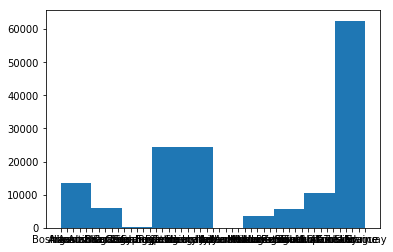

In [29]:
plt.hist(x["country"]);

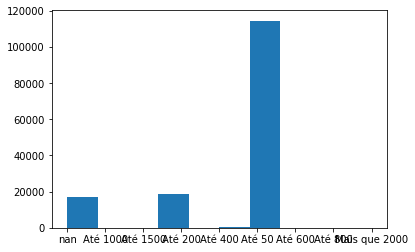

In [30]:
plt.hist(x["Preço"]);

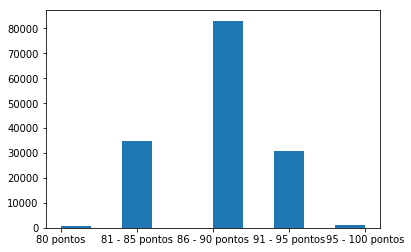

In [31]:
plt.hist(x.Pontos);

___
## C. MODELOS DE PREDIÇÃO

o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS